# Conditional Autoencoder for Asset Pricing - Part 2: The Model

This notebook uses a dataset created using `yfinance` in the notebook [conditional_autoencoder_for_asset_pricing_data](05_conditional_autoencoder_for_asset_pricing_data.ipynb). The results will vary depending on which ticker downloads succeeded.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys, os
from time import time
from pathlib import Path
from itertools import product
from tqdm import tqdm 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dot, Reshape, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard

from sklearn.preprocessing import quantile_transform

from scipy.stats import spearmanr

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
gpu_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [6]:
idx = pd.IndexSlice
sns.set_style('whitegrid')
np.random.seed(42)

In [7]:
results_path = Path('results', 'asset_pricing')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [8]:
characteristics = ['beta', 'betasq', 'chmom', 'dolvol', 'idiovol', 'ill', 'indmom',
                   'maxret', 'mom12m', 'mom1m', 'mom36m', 'mvel', 'retvol', 'turn', 'turn_std']

## Load Data

In [9]:
with pd.HDFStore(results_path / 'autoencoder.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: results\asset_pricing\autoencoder.h5
/close                      frame        (shape->[7559,2784]) 
/factor/beta                frame        (shape->[1857868,1]) 
/factor/betasq              frame        (shape->[1857868,1]) 
/factor/chmom               frame        (shape->[2112739,1]) 
/factor/dolvol              frame        (shape->[2217436,1]) 
/factor/idiovol             frame        (shape->[1857868,1]) 
/factor/ill                 frame        (shape->[2109879,1]) 
/factor/indmom              frame        (shape->[2221733,1]) 
/factor/maxret              frame        (shape->[2230537,1]) 
/factor/mom12m              frame        (shape->[2112739,1]) 
/factor/mom1m               series       (shape->[2242019])   
/factor/mom36m              frame        (shape->[1856586,1]) 
/factor/mvel                frame        (shape->[2252977,1]) 
/factor/retvol              frame        (shape->[2242019,1]) 
/factor/turn                fram

### Weekly returns

In [10]:
data = (pd.read_hdf(results_path / 'autoencoder.h5', 'returns')
        .stack(dropna=False)
        .to_frame('returns')
        .loc[idx['1993':, :], :])

In [11]:
with pd.HDFStore(results_path / 'autoencoder.h5') as store:
    keys = [k[1:] for k in store.keys() if k[1:].startswith('factor')]
    for key in keys:
        data[key.split('/')[-1]] = store[key].squeeze()

In [12]:
characteristics = data.drop('returns', axis=1).columns.tolist()

In [13]:
data['returns_fwd'] = data.returns.unstack('ticker').shift(-1).stack()

In [14]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3925440 entries, (Timestamp('1993-01-01 00:00:00', freq='W-FRI'), 'ABB') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZDGE')
Data columns (total 17 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   returns      2156270 non-null  float64
 1   beta         1857868 non-null  float64
 2   betasq       1857868 non-null  float64
 3   chmom        2051136 non-null  float64
 4   dolvol       2129382 non-null  float64
 5   idiovol      1857868 non-null  float64
 6   ill          2035939 non-null  float64
 7   indmom       2156180 non-null  float64
 8   maxret       2140214 non-null  float64
 9   mom12m       2051136 non-null  float64
 10  mom1m        2148979 non-null  float64
 11  mom36m       1856586 non-null  float64
 12  mvel         2157384 non-null  float64
 13  retvol       2148979 non-null  float64
 14  turn         2116798 non-null  float64
 15  turn_std     2134059 non-null  

In [15]:
nobs_by_date = data.groupby(level='date').count().max(1)
nobs_by_characteristic = pd.melt(data[characteristics].groupby(level='date').count(),
                                 value_name='# Observations',
                                 var_name=['Characteristic'])

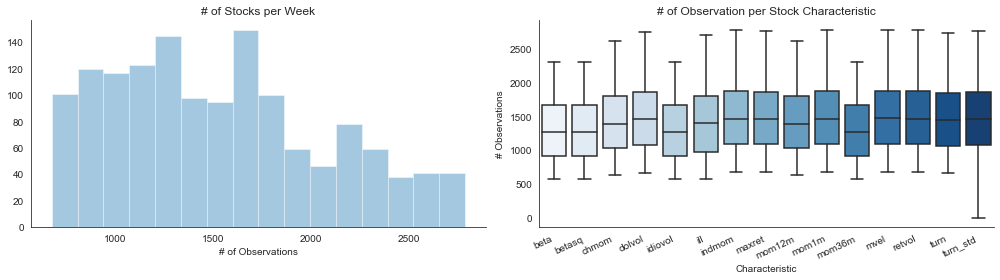

In [16]:
with sns.axes_style("white"):
    fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
    sns.distplot(nobs_by_date, kde=False, ax=axes[0])
    axes[0].set_title('# of Stocks per Week')
    axes[0].set_xlabel('# of Observations')
    sns.boxplot(x='Characteristic',
                y='# Observations',
                data=nobs_by_characteristic,
                ax=axes[1],
                palette='Blues')
    axes[1].set_xticklabels(axes[1].get_xticklabels(),
                            rotation=25,
                            ha='right')
    axes[1].set_title('# of Observation per Stock Characteristic')
    sns.despine()
    fig.tight_layout()

### Rank-normalize characteristics

In [17]:
data.loc[:, characteristics] = (data.loc[:, characteristics]
                                .groupby(level='date')
                                .apply(lambda x: pd.DataFrame(quantile_transform(x, 
                                                                                 copy=True, 
                                                                                 n_quantiles=x.shape[0]),
                                                              columns=characteristics,
                                                              index=x.index.get_level_values('ticker')))
                               .mul(2).sub(1))

In [18]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3925440 entries, (Timestamp('1993-01-01 00:00:00', freq='W-FRI'), 'ABB') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZDGE')
Data columns (total 17 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   returns      2156270 non-null  float64
 1   beta         1857868 non-null  float64
 2   betasq       1857868 non-null  float64
 3   chmom        2051136 non-null  float64
 4   dolvol       2129382 non-null  float64
 5   idiovol      1857868 non-null  float64
 6   ill          2035939 non-null  float64
 7   indmom       2156180 non-null  float64
 8   maxret       2140214 non-null  float64
 9   mom12m       2051136 non-null  float64
 10  mom1m        2148979 non-null  float64
 11  mom36m       1856586 non-null  float64
 12  mvel         2157384 non-null  float64
 13  retvol       2148979 non-null  float64
 14  turn         2116798 non-null  float64
 15  turn_std     2134059 non-null  

In [19]:
data.index.names

FrozenList(['date', 'ticker'])

In [20]:
data.describe()

,returns,beta,betasq,chmom,dolvol,idiovol,ill,indmom,maxret,mom12m,mom1m,mom36m,mvel,retvol,turn,turn_std,returns_fwd
count,2.156270e+06,1.857868e+06,1.857868e+06,2.051136e+06,2.129382e+06,1.857868e+06,2.035939e+06,2.156180e+06,2.140214e+06,2.051136e+06,2.148979e+06,1.856586e+06,2.157384e+06,2.148979e+06,2.116798e+06,2.134059e+06,2.155591e+06
mean,3.309533e-03,-9.376256e-08,-7.963778e-07,3.258167e-08,-3.809044e-07,-1.692967e-07,-9.685771e-07,2.806068e-03,-1.925129e-07,-2.734315e-07,2.102313e-08,-3.920051e-07,-1.357738e-07,-5.273609e-07,-8.604963e-07,-1.453622e-06,3.306790e-03
std,6.556445e-02,5.777876e-01,5.777885e-01,5.777460e-01,5.777329e-01,5.777877e-01,5.777492e-01,5.978149e-01,5.777293e-01,5.777462e-01,5.777267e-01,5.777879e-01,5.777268e-01,5.777289e-01,5.777346e-01,5.777315e-01,6.556966e-02
min,-9.269350e-01,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-9.269350e-01
25%,-2.465594e-02,-5.004476e-01,-5.004513e-01,-5.004080e-01,-5.003835e-01,-5.004278e-01,-5.004156e-01,-4.901186e-01,-5.003786e-01,-5.004113e-01,-5.003141e-01,-5.004662e-01,-5.003800e-01,-5.003823e-01,-5.004120e-01,-5.003853e-01,-2.466186e-02
50%,1.314707e-03,1.026584e-05,6.826282e-06,-2.145832e-05,-9.663654e-06,7.629519e-06,-3.139078e-06,-3.233920e-03,0.000000e+00,6.806038e-06,-1.155841e-05,-1.058744e-05,-1.424108e-05,7.657149e-06,4.315825e-06,-1.228399e-05,1.313649e-03
75%,2.857145e-02,5.004404e-01,5.004425e-01,5.004013e-01,5.003990e-01,5.004399e-01,5.004131e-01,5.080848e-01,5.004162e-01,5.004014e-01,5.003870e-01,5.004373e-01,5.003956e-01,5.003874e-01,5.004144e-01,5.003641e-01,2.857145e-02
max,4.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00


In [21]:
data = data.loc[idx[:'2019', :], :]

In [22]:
data.loc[:, ['returns', 'returns_fwd']] = data.loc[:, ['returns', 'returns_fwd']].clip(lower=-1, upper=1.0)

In [23]:
data = data.fillna(-2)

In [24]:
data.to_hdf(results_path / 'autoencoder.h5', 'model_data')

## Architecture

In [25]:
data = pd.read_hdf(results_path / 'autoencoder.h5', 'model_data')

### Key parameters

In [26]:
n_factors = 3
n_characteristics = len(characteristics)
n_tickers = len(data.index.unique('ticker'))

In [27]:
n_tickers

2784

In [28]:
n_characteristics

15

### Input Layer

In [29]:
input_beta = Input((n_tickers, n_characteristics), name='input_beta')
input_factor = Input((n_tickers,), name='input_factor')

### Stock Characteristics Network

In [30]:
hidden_layer = Dense(units=8, activation='relu', name='hidden_layer')(input_beta)
batch_norm = BatchNormalization(name='batch_norm')(hidden_layer)
output_beta = Dense(units=n_factors, name='output_beta')(batch_norm)

### Factor Network

In [31]:
output_factor = Dense(units=n_factors, name='output_factor')(input_factor)

### Output Layer

In [32]:
output = Dot(axes=(2,1), name='output_layer')([output_beta, output_factor])

### Compile Layer

In [33]:
model = Model(inputs=[input_beta, input_factor], outputs=output)
model.compile(loss='mse', optimizer='adam')

### Automate model generation

In [34]:
def make_model(hidden_units=8, n_factors=3):
    input_beta = Input((n_tickers, n_characteristics), name='input_beta')
    input_factor = Input((n_tickers,), name='input_factor')

    hidden_layer = Dense(units=hidden_units, activation='relu', name='hidden_layer')(input_beta)
    batch_norm = BatchNormalization(name='batch_norm')(hidden_layer)
    
    output_beta = Dense(units=n_factors, name='output_beta')(batch_norm)

    output_factor = Dense(units=n_factors, name='output_factor')(input_factor)

    output = Dot(axes=(2,1), name='output_layer')([output_beta, output_factor])

    model = Model(inputs=[input_beta, input_factor], outputs=output)
    model.compile(loss='mse', optimizer='adam')
    return model

### Model Summary

In [35]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_beta (InputLayer)         [(None, 2784, 15)]   0                                            
__________________________________________________________________________________________________
hidden_layer (Dense)            (None, 2784, 8)      128         input_beta[0][0]                 
__________________________________________________________________________________________________
batch_norm (BatchNormalization) (None, 2784, 8)      32          hidden_layer[0][0]               
__________________________________________________________________________________________________
input_factor (InputLayer)       [(None, 2784)]       0                                            
_______________________________________________________________________________________

## Train Model

### Cross-validation parameters

In [36]:
YEAR = 52

In [37]:
cv = MultipleTimeSeriesCV(n_splits=5, 
                          train_period_length=20*YEAR,
                          test_period_length=1*YEAR,
                          lookahead=1)

In [38]:
def get_train_valid_data(data, train_idx, val_idx):
    train, val = data.iloc[train_idx], data.iloc[val_idx]
    X1_train = train.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
    X1_val = val.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
    X2_train = train.loc[:, 'returns'].unstack('ticker')
    X2_val = val.loc[:, 'returns'].unstack('ticker')
    y_train = train.returns_fwd.unstack('ticker')
    y_val = val.returns_fwd.unstack('ticker')
    return X1_train, X2_train, y_train, X1_val, X2_val, y_val

### Hyperparameter Options

In [39]:
factor_opts = [2, 3, 4, 5, 6]
unit_opts = [8, 16, 32]

In [40]:
param_grid = list(product(unit_opts, factor_opts))

### Run Cross-Validation

In [41]:
batch_size = 256

In [42]:
cols = ['units', 'n_factors', 'fold', 'epoch', 'ic_mean', 
        'ic_daily_mean', 'ic_daily_std', 'ic_daily_median']

In [43]:
start = time()
for units, n_factors in param_grid:
    scores = []
    model = make_model(hidden_units=units, n_factors=n_factors)
    for fold, (train_idx, val_idx) in enumerate(cv.split(data)):
        X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(data,
                                                                                  train_idx,
                                                                                  val_idx)
        for epoch in range(250):
            model.fit([X1_train, X2_train], y_train,
                      batch_size=batch_size,
                      validation_data=([X1_val, X2_val], y_val),
                      epochs=epoch + 1,
                      initial_epoch=epoch,
                      verbose=0, shuffle=True)
            result = (pd.DataFrame({'y_pred': model.predict([X1_val,
                                                             X2_val]).reshape(-1),
                                    'y_true': y_val.stack().values},
                                   index=y_val.stack().index)
                      .replace(-2, np.nan).dropna())
            r0 = spearmanr(result.y_true, result.y_pred)[0]
            r1 = result.groupby(level='date').apply(lambda x: spearmanr(x.y_pred,
                                                                        x.y_true)[0])

            scores.append([units, n_factors, fold, epoch, r0,
                           r1.mean(), r1.std(), r1.median()])
            if epoch % 50 == 0:
                print(f'{format_time(time()-start)} | {n_factors} | {units:02} | {fold:02}-{epoch:03} | {r0:6.2%} | '
                  f'{r1.mean():6.2%} | {r1.median():6.2%}')            
    scores = pd.DataFrame(scores, columns=cols)
    scores.to_hdf(results_path / 'scores.h5', f'{units}/{n_factors}')

00:01:43 | 2 | 08 | 00-000 |  2.26% | -0.79% | -0.61%
00:02:16 | 2 | 08 | 00-050 | -0.11% | -1.19% | -0.44%
00:02:52 | 2 | 08 | 00-100 | -0.32% | -1.44% | -0.94%
00:03:28 | 2 | 08 | 00-150 | -0.51% | -1.57% | -2.20%
00:04:06 | 2 | 08 | 00-200 | -0.58% | -1.60% | -2.18%
00:04:49 | 2 | 08 | 01-000 |  0.26% |  0.56% |  1.57%
00:05:28 | 2 | 08 | 01-050 |  0.64% |  0.56% |  1.11%
00:06:08 | 2 | 08 | 01-100 |  0.54% |  0.48% |  0.66%
00:06:46 | 2 | 08 | 01-150 |  0.48% |  0.40% |  0.86%
00:07:25 | 2 | 08 | 01-200 |  0.83% |  0.34% |  0.82%
00:08:08 | 2 | 08 | 02-000 |  0.89% |  1.25% |  0.35%
00:08:49 | 2 | 08 | 02-050 |  0.68% |  1.08% |  0.52%
00:09:28 | 2 | 08 | 02-100 |  0.63% |  1.07% |  0.33%
00:10:07 | 2 | 08 | 02-150 |  0.53% |  0.97% |  1.66%
00:10:46 | 2 | 08 | 02-200 |  0.43% |  0.72% |  1.03%
00:11:28 | 2 | 08 | 03-000 |  0.07% | -0.54% |  0.76%
00:12:08 | 2 | 08 | 03-050 | -0.56% | -1.07% |  0.20%
00:12:47 | 2 | 08 | 03-100 | -0.52% | -0.41% | -0.07%
00:13:26 | 2 | 08 | 03-150 |

01:16:48 | 3 | 16 | 00-100 | -0.73% | -1.17% | -0.86%
01:17:14 | 3 | 16 | 00-150 | -0.20% | -0.54% | -0.48%
01:17:41 | 3 | 16 | 00-200 | -0.09% | -0.31% |  0.12%
01:18:09 | 3 | 16 | 01-000 | -0.05% | -0.36% | -0.58%
01:18:36 | 3 | 16 | 01-050 |  0.01% | -0.22% | -0.26%
01:19:03 | 3 | 16 | 01-100 |  0.03% | -0.22% | -0.42%
01:19:29 | 3 | 16 | 01-150 |  0.07% | -0.04% |  0.49%
01:19:56 | 3 | 16 | 01-200 |  0.18% |  0.09% |  1.23%
01:20:24 | 3 | 16 | 02-000 |  0.40% |  0.23% | -0.14%
01:20:50 | 3 | 16 | 02-050 |  1.03% |  0.19% |  0.34%
01:21:16 | 3 | 16 | 02-100 |  0.97% |  0.08% | -0.14%
01:21:43 | 3 | 16 | 02-150 |  0.70% | -0.21% | -0.52%
01:22:09 | 3 | 16 | 02-200 |  0.35% | -0.34% | -0.54%
01:22:37 | 3 | 16 | 03-000 |  0.31% | -0.43% | -0.12%
01:23:03 | 3 | 16 | 03-050 |  0.07% | -0.79% | -0.30%
01:23:29 | 3 | 16 | 03-100 | -0.02% | -0.90% | -0.04%
01:23:55 | 3 | 16 | 03-150 |  0.22% | -0.49% |  0.23%
01:24:22 | 3 | 16 | 03-200 |  0.16% | -0.70% | -0.45%
01:24:50 | 3 | 16 | 04-000 |

02:33:17 | 4 | 32 | 00-200 | -1.50% | -0.17% |  0.82%
02:33:52 | 4 | 32 | 01-000 | -0.16% | -0.25% | -0.19%
02:34:25 | 4 | 32 | 01-050 | -0.56% | -0.21% | -0.28%
02:34:57 | 4 | 32 | 01-100 | -0.48% | -0.13% |  0.04%
02:35:29 | 4 | 32 | 01-150 | -0.62% |  0.01% |  0.20%
02:36:02 | 4 | 32 | 01-200 | -0.64% |  0.13% | -0.31%
02:36:37 | 4 | 32 | 02-000 |  0.07% |  0.57% |  0.07%
02:37:09 | 4 | 32 | 02-050 | -0.09% |  0.60% | -0.21%
02:37:41 | 4 | 32 | 02-100 | -0.16% |  0.67% | -0.03%
02:38:13 | 4 | 32 | 02-150 | -0.26% |  0.68% | -0.16%
02:38:45 | 4 | 32 | 02-200 | -0.45% |  0.53% |  0.36%
02:39:20 | 4 | 32 | 03-000 | -0.01% |  0.10% | -0.31%
02:39:52 | 4 | 32 | 03-050 | -0.11% | -0.11% | -0.22%
02:40:25 | 4 | 32 | 03-100 |  0.16% |  0.33% |  0.27%
02:40:57 | 4 | 32 | 03-150 |  0.01% | -0.04% |  0.20%
02:41:29 | 4 | 32 | 03-200 |  0.18% |  0.34% |  1.05%
02:42:04 | 4 | 32 | 04-000 |  2.72% |  2.18% |  2.00%
02:42:37 | 4 | 32 | 04-050 |  1.76% |  1.12% |  0.43%
02:43:09 | 4 | 32 | 04-100 |

### Evaluate Results

In [44]:
scores = []
with pd.HDFStore(results_path / 'scores.h5') as store:
    for key in store.keys():
        scores.append(store[key])
scores = pd.concat(scores)

In [45]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18750 entries, 0 to 1249
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   units            18750 non-null  int64  
 1   n_factors        18750 non-null  int64  
 2   fold             18750 non-null  int64  
 3   epoch            18750 non-null  int64  
 4   ic_mean          18750 non-null  float64
 5   ic_daily_mean    18750 non-null  float64
 6   ic_daily_std     18750 non-null  float64
 7   ic_daily_median  18750 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 1.3 MB


In [46]:
avg = (scores.groupby(['n_factors', 'units', 'epoch'])
       ['ic_mean', 'ic_daily_mean', 'ic_daily_median']
       .mean()
      .reset_index())

In [47]:
avg.nlargest(n=20, columns=['ic_daily_median'])

,n_factors,units,epoch,ic_mean,ic_daily_mean,ic_daily_median
3677,6,32,177,0.017459,0.010529,0.020403
3536,6,32,36,0.018779,0.012097,0.020252
3719,6,32,219,0.015723,0.011697,0.019695
3643,6,32,143,0.017609,0.009729,0.019490
3503,6,32,3,0.020168,0.016571,0.018448
3697,6,32,197,0.017300,0.009420,0.018404
3699,6,32,199,0.017799,0.011242,0.018051
3669,6,32,169,0.016463,0.008991,0.017947
3516,6,32,16,0.018123,0.012883,0.017712
3521,6,32,21,0.017278,0.010284,0.017521


In [48]:
top = (avg.groupby(['n_factors', 'units'])
       .apply(lambda x: x.nlargest(n=5, columns=['ic_daily_median']))
       .reset_index(-1, drop=True))

top.nlargest(n=5, columns=['ic_daily_median'])

n_factors  units  epoch   ic_mean  ic_daily_mean  \
n_factors units                                                     
6         32             6     32    177  0.017459       0.010529   
          32             6     32     36  0.018779       0.012097   
          32             6     32    219  0.015723       0.011697   
          32             6     32    143  0.017609       0.009729   
          32             6     32      3  0.020168       0.016571   

                 ic_daily_median  
n_factors units                   
6         32            0.020403  
          32            0.020252  
          32            0.019695  
          32            0.019490  
          32            0.018448

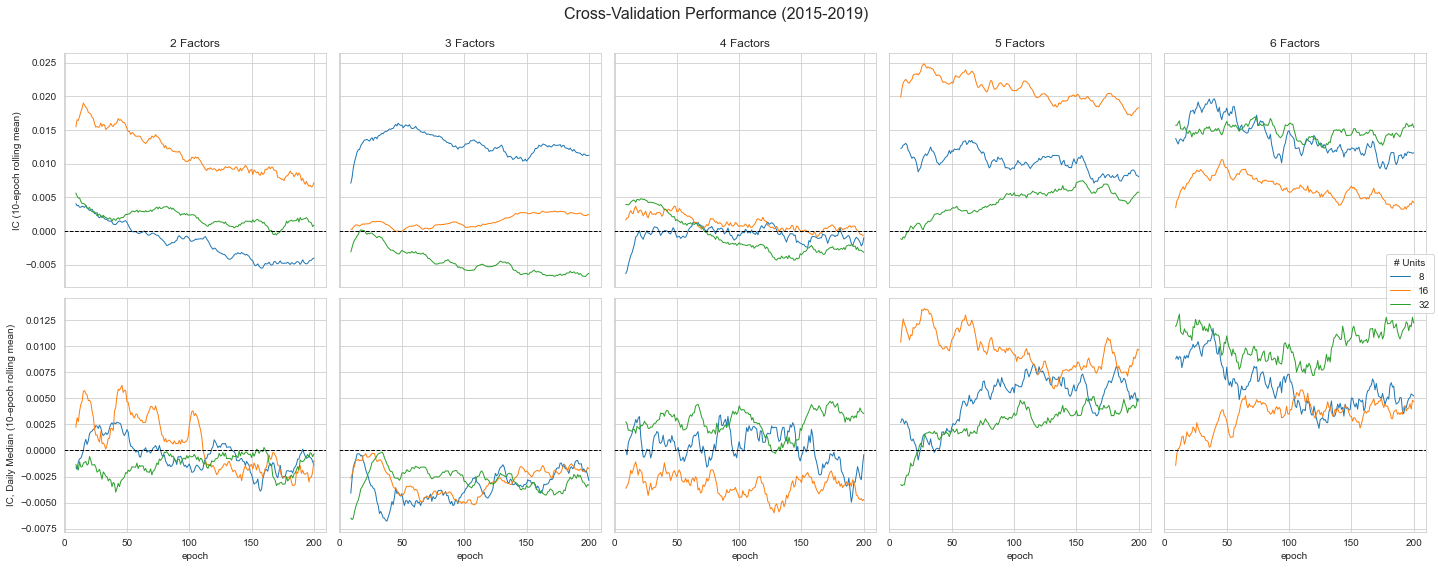

In [49]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20, 8), sharey='row', sharex=True)

for n in range(2, 7):
    df = avg[avg.n_factors==n].pivot(index='epoch', columns='units', values='ic_mean')
    df.rolling(10).mean().loc[:200].plot(ax=axes[0][n-2], lw=1, title=f'{n} Factors')
    axes[0][n-2].axhline(0, ls='--', c='k', lw=1)
    axes[0][n-2].get_legend().remove()
    axes[0][n-2].set_ylabel('IC (10-epoch rolling mean)')

    df = avg[avg.n_factors==n].pivot(index='epoch', columns='units', values='ic_daily_median')
    df.rolling(10).mean().loc[:200].plot(ax=axes[1][n-2], lw=1)
    axes[1][n-2].axhline(0, ls='--', c='k', lw=1)
    axes[1][n-2].get_legend().remove()
    axes[1][n-2].set_ylabel('IC, Daily Median (10-epoch rolling mean)')

handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', title='# Units')
fig.suptitle('Cross-Validation Performance (2015-2019)', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig(results_path / 'cv_performance', dpi=300);

## Generate Predictions

We'll average over a range of epochs that appears to deliver good predictions.

In [50]:
n_factors = 4
units = 32
batch_size = 32
first_epoch = 50
last_epoch = 80

In [51]:
predictions = []
for epoch in tqdm(list(range(first_epoch, last_epoch))):
    epoch_preds = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(data)):
        X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(data,
                                                                                  train_idx,
                                                                                  val_idx)

        model = make_model(n_factors=n_factors, hidden_units=units)
        model.fit([X1_train, X2_train], y_train,
                  batch_size=batch_size,
                  epochs=epoch,
                  verbose=0,
                  shuffle=True)
        epoch_preds.append(pd.Series(model.predict([X1_val, X2_val]).reshape(-1),
                                     index=y_val.stack().index).to_frame(epoch))

    predictions.append(pd.concat(epoch_preds))

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

  3%|██▊                                                                                | 1/30 [01:16<37:04, 76.71s/it]

  7%|█████▌                                                                             | 2/30 [02:36<36:37, 78.48s/it]

 10%|████████▎                                                                          | 3/30 [03:59<36:18, 80.69s/it]

 13%|███████████                                                                        | 4/30 [05:23<35:24, 81.73s/it]

 17%|█████████████▊                                                                     | 5/30 [06:48<34:33, 82.95s/it]

 20%|████████████████▌                                                                  | 6/30 [08:11<33:13, 83.06s/it]

 23%|███████████████████▎                                                               | 7/30 [09:35<31:57, 83.38s/it]

 27%|██████████████████████▏                                                            | 8/30 [10:59<30:41, 83.70s/it]

 30%|████████████████████████▉                                                          | 9/30 [12:26<29:34, 84.50s/it]

 33%|███████████████████████████▎                                                      | 10/30 [13:55<28:39, 85.97s/it]

 37%|██████████████████████████████                                                    | 11/30 [15:58<30:50, 97.38s/it]

 40%|████████████████████████████████▍                                                | 12/30 [18:02<31:38, 105.46s/it]

 43%|███████████████████████████████████                                              | 13/30 [19:51<30:12, 106.62s/it]

 47%|█████████████████████████████████████▊                                           | 14/30 [21:27<27:30, 103.16s/it]

 50%|████████████████████████████████████████▌                                        | 15/30 [23:05<25:26, 101.75s/it]

 53%|███████████████████████████████████████████▏                                     | 16/30 [24:45<23:35, 101.10s/it]

 57%|█████████████████████████████████████████████▉                                   | 17/30 [26:32<22:20, 103.09s/it]

 60%|████████████████████████████████████████████████▌                                | 18/30 [28:23<21:03, 105.32s/it]

 63%|███████████████████████████████████████████████████▎                             | 19/30 [30:12<19:31, 106.54s/it]

 67%|██████████████████████████████████████████████████████                           | 20/30 [31:57<17:39, 105.96s/it]

 70%|████████████████████████████████████████████████████████▋                        | 21/30 [33:41<15:49, 105.49s/it]

 73%|███████████████████████████████████████████████████████████▍                     | 22/30 [35:27<14:03, 105.49s/it]

 77%|██████████████████████████████████████████████████████████████                   | 23/30 [37:13<12:20, 105.80s/it]

 80%|████████████████████████████████████████████████████████████████▊                | 24/30 [39:05<10:44, 107.47s/it]

 83%|███████████████████████████████████████████████████████████████████▌             | 25/30 [41:20<09:39, 115.91s/it]

 87%|██████████████████████████████████████████████████████████████████████▏          | 26/30 [43:45<08:18, 124.65s/it]

 90%|████████████████████████████████████████████████████████████████████████▉        | 27/30 [46:08<06:29, 129.97s/it]

 93%|███████████████████████████████████████████████████████████████████████████▌     | 28/30 [48:28<04:26, 133.12s/it]

 97%|██████████████████████████████████████████████████████████████████████████████▎  | 29/30 [50:50<02:15, 135.80s/it]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [53:14<00:00, 106.49s/it]


In [52]:
predictions_combined = pd.concat(predictions, axis=1).sort_index()   

In [53]:
predictions_combined.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 723840 entries, (Timestamp('2015-01-09 00:00:00'), 'A') to (Timestamp('2019-12-27 00:00:00'), 'ZYXI')
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   50      723840 non-null  float32
 1   51      723840 non-null  float32
 2   52      723840 non-null  float32
 3   53      723840 non-null  float32
 4   54      723840 non-null  float32
 5   55      723840 non-null  float32
 6   56      723840 non-null  float32
 7   57      723840 non-null  float32
 8   58      723840 non-null  float32
 9   59      723840 non-null  float32
 10  60      723840 non-null  float32
 11  61      723840 non-null  float32
 12  62      723840 non-null  float32
 13  63      723840 non-null  float32
 14  64      723840 non-null  float32
 15  65      723840 non-null  float32
 16  66      723840 non-null  float32
 17  67      723840 non-null  float32
 18  68      723840 non-null  float32
 19  69      7238

In [54]:
predictions_combined.to_hdf(results_path / 'predictions.h5', 'predictions')